In [2]:
# !pip install mlxtend
# !pip install numpy scipy pandas scikit-learn


In [3]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
# from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import color
import seaborn as sns
import pandas as pd


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\raduf\.cache\kagglehub\datasets\moltean\fruits\versions\11


In [5]:
img_size = (100, 100)  # Poți ajusta dimensiunea după necesitate
batch_size = 32

# Directorul de antrenare și testare
base_path = os.path.join(path, "fruits-360_dataset_100x100", "fruits-360")
train_dir = os.path.join(base_path, "Training")
test_dir = os.path.join(base_path, "Test")


In [6]:
# Generatoare de date
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Încărcarea imaginilor
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [7]:
# Obține primul lot de imagini și etichete
images, labels = train_generator[0]
class_names = list(train_generator.class_indices.keys())
# plt.figure(figsize=(20, 20))
# for i in range(len(images)):
#     plt.subplot(8, 4, i+1)
#     plt.imshow(images[i])
#     label = np.argmax(labels[i])
#     plt.title(class_names[label])
#     plt.axis('off')
# plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


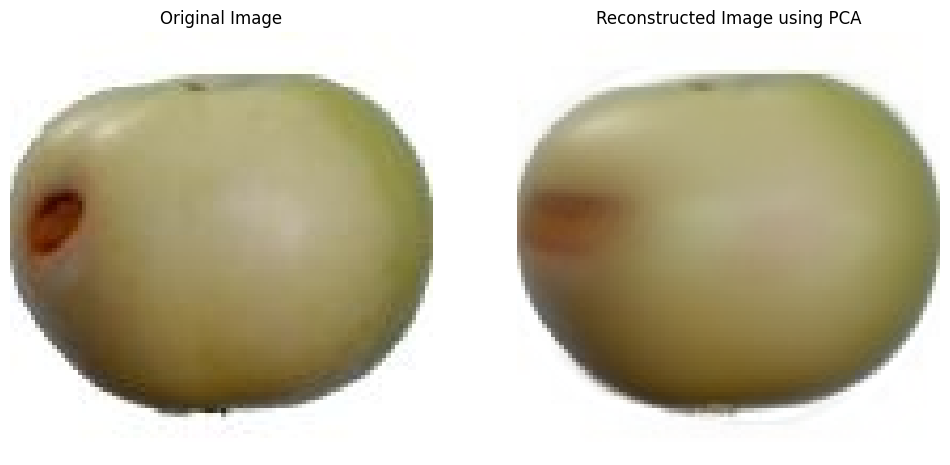

In [8]:
# PCA pe setul de TEST pentru reconstrucția unei imagini
#aleg un nr de componente pe care sa le pastrez
pca = PCA(n_components=5)

# fac mai intai flatten pentru a pasa modelului un array , dupa care cu ajutprul la metoda fit transform chestie fac modelul de pca 
X_test_flat = test_generator[1][0].reshape(-1, img_size[0] * img_size[1] * 3)
X_test_pca = pca.fit_transform(X_test_flat)

# Reconstruim imaginea din setul de test
reconstructed_image_pca = pca.inverse_transform(X_test_pca[20]).reshape(img_size[0], img_size[1], 3)

# Imaginea originală (corespondentă imaginii reconstruite)
original_image = X_test_flat[20].reshape(img_size[0], img_size[1], 3)

# Vizualizare
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Imaginea originală
ax[0].imshow(original_image)  # Normalizare între 0-1 pentru vizualizare corectă
ax[0].set_title('Original Image')
ax[0].axis('off')

# Imaginea reconstruită
ax[1].imshow(reconstructed_image_pca)  # Normalizare între 0-1 pentru vizualizare
ax[1].set_title('Reconstructed Image using PCA')
ax[1].axis('off')

plt.show()



In [9]:


# Funcție pentru a aplica HOG pe un set de imagini
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Conversie în grayscale pentru HOG
        gray_img = color.rgb2gray(img)
        features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

# Extragem atributele HOG din datele de antrenare
X_train_hog = extract_hog_features(train_generator[0][0])

# Vizualizare dimensiune atribute
print(f"Dimensiunea atributelor HOG: {X_train_hog.shape}")

Dimensiunea atributelor HOG: (32, 2)


C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


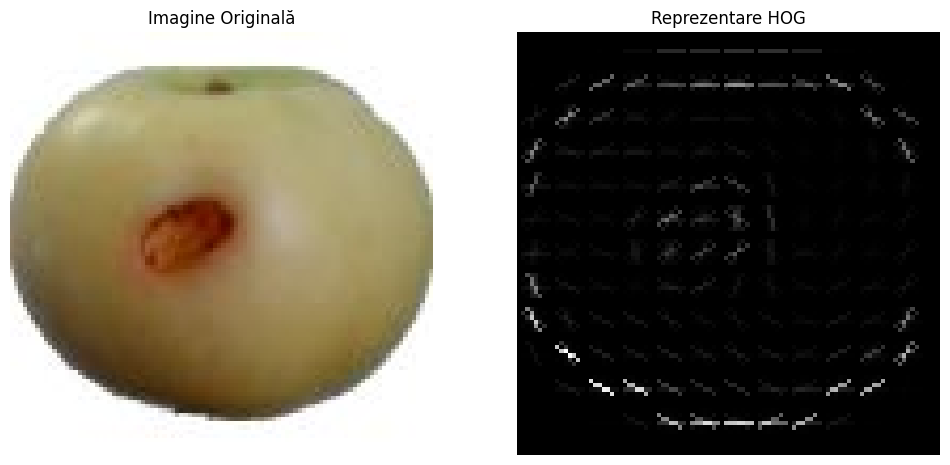

In [10]:
# Selectăm o imagine din setul de date
img = test_generator[1][0][10]  # Prima imagine din setul de antrenament

# Extragem caracteristicile HOG pentru imaginea selectată
hog_features, hog_image = hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8),
							  cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

# Afișăm imaginea originală și cea modificată (HOG)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Imaginea originală
ax[0].imshow(img)
ax[0].set_title('Imagine Originală')
ax[0].axis('off')

# Imaginea modificată cu HOG
ax[1].imshow(hog_image, cmap='gray')
ax[1].set_title('Reprezentare HOG')
ax[1].axis('off')

plt.show()


## 4.2

<Figure size 2000x800 with 0 Axes>

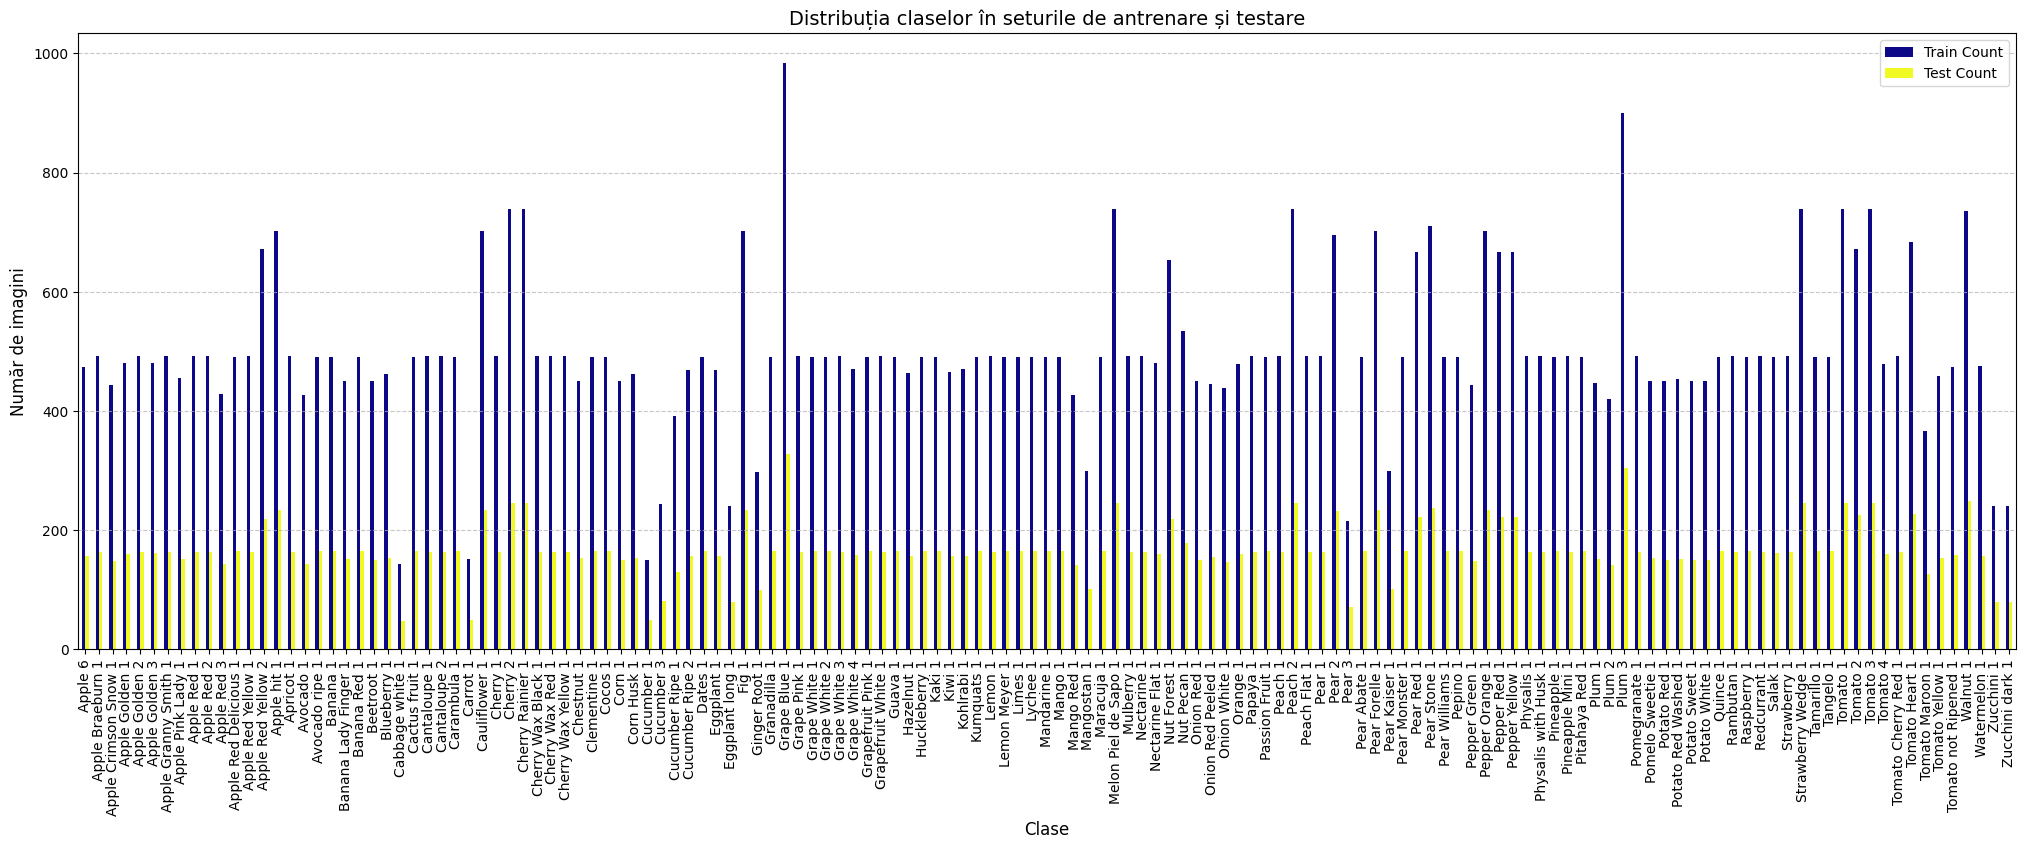

In [11]:
labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())

test_class_names = list(test_generator.class_indices.keys())
test_labels = test_generator.classes

# Creare DataFrame pentru distribuția claselor în setul de antrenare
df_train = pd.DataFrame({'Label': labels})
class_distribution_train = df_train['Label'].value_counts().sort_index()

# Creare DataFrame pentru distribuția claselor în setul de testare
df_test = pd.DataFrame({'Label': test_labels})
class_distribution_test = df_test['Label'].value_counts().sort_index()

# Combinare distribuții într-un singur DataFrame
combined_df = pd.DataFrame({
    'Class': class_names,
    'Train Count': class_distribution_train.values,
    'Test Count': class_distribution_test.values
})

# Vizualizare distribuții
plt.figure(figsize=(20, 8))
combined_df.set_index('Class').plot(kind='bar', colormap='plasma', figsize=(25, 8))
plt.xticks(rotation=90, fontsize=10)
plt.title('Distribuția claselor în seturile de antrenare și testare', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Număr de imagini', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
# # Obține distribuția claselor
# class_counts = pd.DataFrame({
#     'Class': [class_names[np.argmax(label)] for label in labels],
#     'Count': np.sum(labels, axis=0)
# })

# plt.figure(figsize=(12, 8))
# sns.barplot(data=class_counts, x='Class', y='Count', order=class_counts.sort_values('Count', ascending=False)['Class'])
# plt.xticks(rotation=90)
# plt.title('Distribuția claselor în setul de antrenare')
# plt.show()


In [13]:
# pca = PCA(n_components=10)


# # Asigurăm alinierea datelor pentru PCA
# X_train_flat = train_generator[1][0].reshape(-1, img_size[0] * img_size[1] * 3)  # Flattening input
# X_train_pca = pca.fit_transform(X_train_flat)  # Aplicăm PCA

# plt.figure(figsize=(8, 5))
# plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
# plt.title("Varianța cumulativă explicată de componentele principale")
# plt.xlabel("Numărul de componente principale")
# plt.ylabel("Varianță cumulativă explicată")
# plt.grid()
# plt.show()




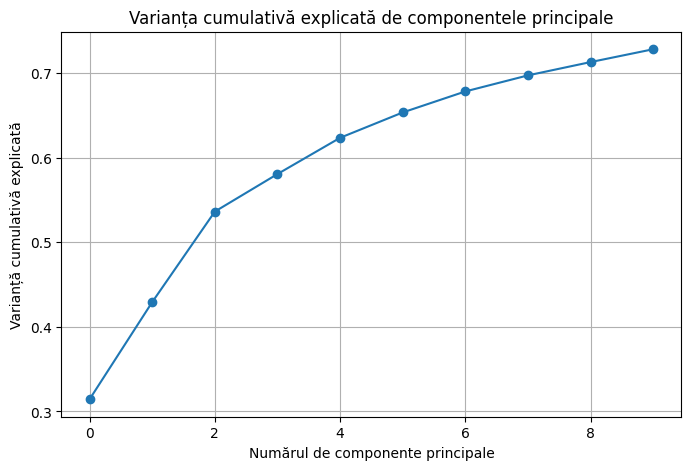

In [25]:

# Parametri
n_components = 10  # Numărul de componente principale
img_size = (100, 100)  # Înlocuiește cu dimensiunea reală a imaginilor tale

# Extragem toate imaginile din generator
# Extragem datele din generator
X_test = np.concatenate([test_generator[i][0] for i in range(len(test_generator))], axis=0)

# Aplatizăm imaginile pentru PCA
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Aplicăm PCA
pca = PCA(n_components=n_components)
X_test_pca = pca.fit_transform(X_test_flat)

# Vizualizăm varianța cumulativă explicată
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Varianța cumulativă explicată de componentele principale")
plt.xlabel("Numărul de componente principale")
plt.ylabel("Varianță cumulativă explicată")
plt.grid()
plt.show()

